<div align="center">
    <div style="position: relative; max-width: 2500px; height: auto;">
        <img src="https://github.com/Kwack0202/VSCode_markdown_IMG/blob/main/earth-seen-from-space.jpg?raw=true" width="100%" style="border-radius:10px; max-height: 550px;">
        <div style="position: absolute; top: 50%; left: 50%; transform: translate(-50%, -50%); text-align: center; color: white; font-size: 60px; font-weight: bold; text-shadow: 2px 2px 4px #000;">
            <span style="padding: 10px; border-radius: 10px;">Satellite IMG Segmentation</span>
        </div>
    </div>
</div>

------------------------------------------
## Openmmlab 코드 실행 환경준비

#### **step 0.** 작업환경 확인 (C언어, 파이썬, VSC 등)
- C++이 설치되지 않으면 실행 오류남

#### **step 1.** 가상환경 생성
- conda create --name openmmlab python=3.8 -y
- conda activate openmmlab

#### **step 2.** 관련 패키지 생성 (프롬프트에서 설치)
- pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118
- pip install -U openmim
- mim install mmengine
- mim install "mmcv>=2.0.0"
- pip install wandb

#### **step 3.** MMsegmentation git 연결하기
`git bash 사용`
- **git clone -b main https://github.com/open-mmlab/mmsegmentation.git**

`anaconda prompt 사용`
- **cd C:\Users\coden\OneDrive\바탕 화면\Building\mmsegmentation**
- **pip install -v -e .** 

#### **step 4.** SegLocalVisualizer 코드 수정
    def __init__(self,
                 draw: bool = False,
                 interval: int = 50,
                 show: bool = False,
                 wait_time: float = 0.,
                 backend_args: Optional[dict] = None):
        self._visualizer: SegLocalVisualizer = SegLocalVisualizer.get_instance(name="Visualizer")
        self.interval = interval
        self.show = show

## Import

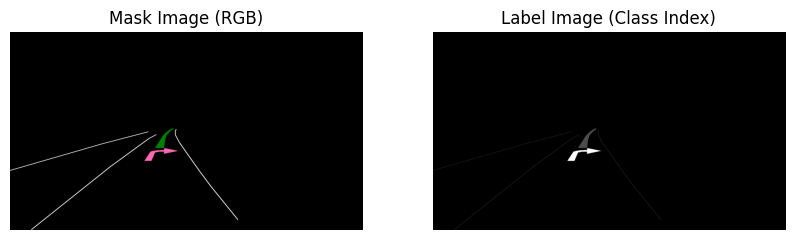

Unique class indices in the label image: [ 0  1  3 10]
Unique colors in the mask image: [[  0   0   0]
 [  0 128   0]
 [255 105 180]
 [255 255 255]]


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# 업로드된 이미지 파일 경로
mask_image_path = './Roadmark/Masked_Images/0101_light_clear_smooth_01000000_mask.png'
label_image_path = './Roadmark/Labels/0101_light_clear_smooth_01000000_label.png'

# 이미지 읽기
mask_image = Image.open(mask_image_path)
label_image = Image.open(label_image_path)

# 이미지 배열로 변환
mask_array = np.array(mask_image)
label_array = np.array(label_image)

# 색상 -> ID 매핑 함수
def clr2id(clr):
    return clr[0] + clr[1] * 255 + clr[2] * 255 * 255

# 각 supercategory별로 색상 지정 (RGB 형태)
colors = {
    'background' : (0, 0, 0),             # black
    'roadlane': (255, 255, 255),          # white
    'roadlane_ban': (255, 255, 0),        # yellow
    'guidance': (0, 128, 0),              # green
    'direction_ban': (0, 0, 255),         # blue
    'speed_restriction': (255, 0, 0),     # red
    'protection_zone': (255, 165, 0),     # orange
    'direction_guidance': (0, 191, 255),  # DeepSkyBlue
    'stop_lane': (165, 42, 42),           # brown
    'crosswalk': (0, 255, 255),           # cyan
    'direction': (255, 105, 180),         # pink
    'etc': (128, 0, 128),                 # purple
}

id_tab = {k: clr2id(v) for k, v in colors.items()}

# 이미지 시각화
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Mask Image (RGB)')
plt.imshow(mask_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Label Image (Class Index)')
plt.imshow(label_image, cmap='gray')
plt.axis('off')

plt.show()

# 각 클래스 인덱스 확인
unique_labels = np.unique(label_array)
print("Unique class indices in the label image:", unique_labels)

# 각 색상에 해당하는 픽셀 값 확인
unique_colors = np.unique(mask_array.reshape(-1, mask_array.shape[2]), axis=0)
print("Unique colors in the mask image:", unique_colors)

In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.0.0+cu118 True


In [2]:
import pandas as pd
import numpy as np
from PIL import Image

import os
import shutil
import random

import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Masking IMG Generating

In [4]:
df = pd.read_csv('./train.csv')

In [5]:
''' # train_mask 폴더 생성
output_folder = 'train_mask'
os.makedirs(output_folder, exist_ok=True)

# 이미지를 불러와 마스킹 이미지 생성 및 저장
for index, row in tqdm(df.iterrows()):
    img_id = row['img_id']
    img_path = row['img_path']
    mask_rle = row['mask_rle']

    # 이미지 불러오기
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # RLE 디코딩 및 마스킹 이미지 생성
    mask = rle_decode(mask_rle, img.shape)

    # 마스킹 이미지 저장
    mask_image_path = os.path.join(output_folder, f'{img_id}_mask.png')
    cv2.imwrite(mask_image_path, mask * 1)  # 값이 1인 부분은 255로 저장 (바이너리 마스크) '''

7140it [03:39, 32.59it/s]


In [4]:
from PIL import Image
import os
import random

random_seed = 42  # You can choose any integer value
random.seed(random_seed)

# 원본 이미지와 마스크 이미지의 경로
original_image_path = "./train_img/"
mask_image_path = "./train_mask/"

# 저장할 경로
output_image_path = "./image_512x512/"
output_mask_path = "./mask_512x512/"
os.makedirs(output_image_path, exist_ok=True)
os.makedirs(output_mask_path, exist_ok=True)

# 이미지 크기
original_size = (1024, 1024)
target_size = (512, 512)

# 이미지 파일 목록 가져오기
image_files = os.listdir(original_image_path)

# 이미지 crop 및 저장
for image_file in tqdm(image_files):
    if image_file.endswith(".png"):  # PNG 확장자인 경우에만 처리
        image_path = os.path.join(original_image_path, image_file)
        mask_file = image_file.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_image_path, mask_file)

        # 이미지 열기
        original_image = Image.open(image_path)
        mask_image = Image.open(mask_path)

        # 랜덤한 위치에서 crop
        left = random.randint(0, original_size[0] - target_size[0])
        top = random.randint(0, original_size[1] - target_size[1])
        right = left + target_size[0]
        bottom = top + target_size[1]

        # 이미지 crop
        cropped_image = original_image.crop((left, top, right, bottom))
        cropped_mask = mask_image.crop((left, top, right, bottom))

        # 저장할 경로 및 파일명 설정
        output_image_file = os.path.join(output_image_path, image_file)
        output_mask_file = os.path.join(output_mask_path, mask_file)

        # 이미지 저장
        cropped_image.save(output_image_file)
        cropped_mask.save(output_mask_file)

  0%|          | 0/7140 [00:00<?, ?it/s]

100%|██████████| 7140/7140 [13:15<00:00,  8.97it/s]


In [5]:
# 이미지 파일 경로 설정
image_file_path = "./mask_512x512/TRAIN_0000_mask.png"

# 이미지 파일을 NumPy 배열로 변환
with Image.open(image_file_path) as img:
    img_array = np.array(img)

# 이미지 배열 출력
print("Image Shape:", img_array.shape)  # 이미지 배열의 크기 출력
print("Image Array:")
print(img_array)  # 이미지 배열 전체 출력

Image Shape: (512, 512)
Image Array:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Train Valid Split

In [6]:
# 원본 이미지와 마스크 이미지가 있는 경로
img_path = "./image_512x512/"
mask_path = "./mask_512x512/"

# 분할된 데이터를 저장할 경로
train_img_dest = "./train/img[0~100]/"
train_mask_dest = "./train/mask[0~100]/"
valid_img_dest = "./valid/img/"
valid_mask_dest = "./valid/mask/"

# 디렉토리 생성
os.makedirs(train_img_dest, exist_ok=True)
os.makedirs(train_mask_dest, exist_ok=True)
os.makedirs(valid_img_dest, exist_ok=True)
os.makedirs(valid_mask_dest, exist_ok=True)

In [7]:
# 시드 설정
seed_value = 42
random.seed(seed_value)

# 이미지 파일 목록 가져오기
img_files = [f for f in os.listdir(img_path) if f.endswith(".png")]

# 데이터를 섞어 무작위로 나누기
random.shuffle(img_files)
split_ratio = 0.9
split_index = int(len(img_files) * split_ratio)

train_files = img_files[:split_index]
valid_files = img_files[split_index:]

In [8]:
# train 이미지 및 마스크 복사
for file in tqdm(train_files):
    img_src = os.path.join(img_path, file)
    mask_src = os.path.join(mask_path, file.replace(".png", "_mask.png"))
    
    shutil.copy(img_src, train_img_dest)
    shutil.copy(mask_src, train_mask_dest)

# valid 이미지 및 마스크 복사
for file in tqdm(valid_files):
    img_src = os.path.join(img_path, file)
    mask_src = os.path.join(mask_path, file.replace(".png", "_mask.png"))
    
    shutil.copy(img_src, valid_img_dest)
    shutil.copy(mask_src, valid_mask_dest)

100%|██████████| 714/714 [00:09<00:00, 78.79it/s]


## Building 면적 확인

In [18]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 마스킹 이미지가 있는 디렉토리 경로
mask_dir = "./train_mask/"

# 디렉토리 내의 모든 파일 가져오기
mask_files = os.listdir(mask_dir)

# 객체 크기를 저장할 리스트
object_sizes = []

# 모든 마스크 이미지에 대해 반복
for mask_file in tqdm(mask_files):
    # 이미지 읽기
    mask_path = os.path.join(mask_dir, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # 객체 감지 (흰색 영역)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 객체 크기 측정 및 저장
    for contour in contours:
        object_size = cv2.contourArea(contour)
        object_sizes.append(object_size)

  0%|          | 0/7140 [00:00<?, ?it/s]

100%|██████████| 7140/7140 [00:42<00:00, 167.88it/s]


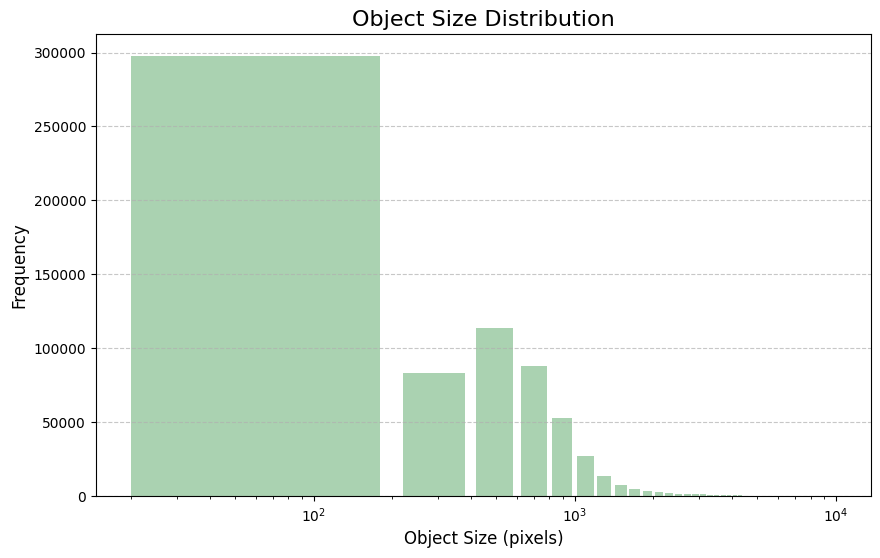

In [19]:
plt.figure(figsize=(10, 6))
plt.hist(object_sizes, bins=50, range=(0, 10000), color='#86bf91', rwidth=0.8, alpha=0.7)
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

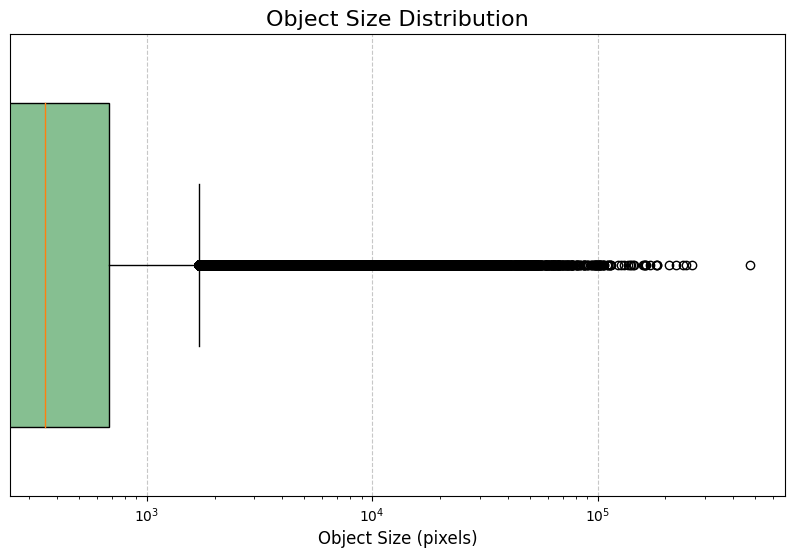

In [23]:
plt.figure(figsize=(10, 6))
plt.boxplot(object_sizes, vert=False, widths=0.7, patch_artist=True, boxprops=dict(facecolor='#86bf91', color='black'))
plt.xscale('log')  # Logarithmic scale on the x-axis for better representation
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.title('Object Size Distribution', fontsize=16)
plt.xlabel('Object Size (pixels)', fontsize=12)
plt.yticks([])
plt.xticks(fontsize=10)
plt.show()

## Building area ratio of masking image

In [9]:
# 경로 설정
folder_path = "./train/mask[0~100]"

# 폴더 내의 모든 파일 가져오기
mask_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# 결과를 저장할 리스트 초기화
data = []

# 각 mask 이미지 처리
for mask_file in tqdm(mask_files, desc="Processing", unit="image"):
    mask_image_path = os.path.join(folder_path, mask_file)
    
    # Mask 이미지를 NumPy 배열로 불러오기
    mask_image = np.array(Image.open(mask_image_path))
    
    # 전체 픽셀 수
    total_pixels = mask_image.size
    
    # Object(마스크)인 픽셀 수 계산
    object_pixels = np.count_nonzero(mask_image)  # nonzero 픽셀이 Object(마스크) 부분
    
    # 배경인 픽셀 수 계산
    background_pixels = total_pixels - object_pixels
    
    # Object Ratio 계산
    object_ratio = object_pixels / total_pixels
    
    # Background Ratio 계산
    background_ratio = background_pixels / total_pixels
    
    # 결과 데이터에 추가
    data.append({
        "Mask Image": mask_file,
        "Object Ratio": object_ratio * 100,
        "Background Ratio": background_ratio * 100
    })

# 데이터를 pandas DataFrame으로 변환
building_ratio = pd.DataFrame(data)
building_ratio

Processing: 100%|██████████| 6426/6426 [00:35<00:00, 183.47image/s]


,Mask Image,Object Ratio,Background Ratio
0,TRAIN_0000_mask.png,1.979065,98.020935
1,TRAIN_0001_mask.png,9.942627,90.057373
2,TRAIN_0002_mask.png,0.326920,99.673080
3,TRAIN_0005_mask.png,1.546860,98.453140
4,TRAIN_0006_mask.png,0.908279,99.091721
...,...,...,...
6421,TRAIN_7135_mask.png,9.630966,90.369034
6422,TRAIN_7136_mask.png,3.519821,96.480179
6423,TRAIN_7137_mask.png,5.911636,94.088364
6424,TRAIN_7138_mask.png,6.207275,93.792725


Mean Object Ratio: 5.95


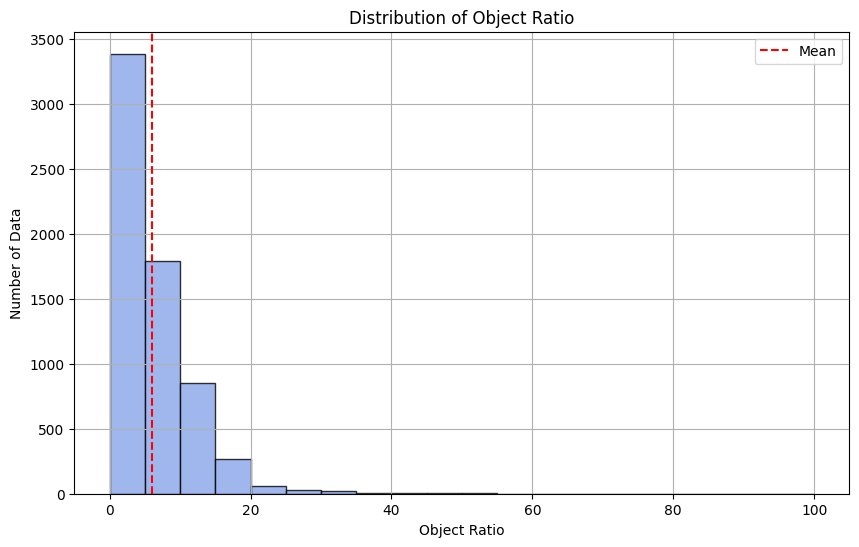

In [10]:
# X축 데이터 생성
x_ticks = np.arange(0, 101, 5)  # 0부터 100까지 5% 단위로

# 평균값 계산
object_ratio_mean = building_ratio["Object Ratio"].mean()

# 시각화
plt.figure(figsize=(10, 6))
plt.hist(building_ratio["Object Ratio"], bins=x_ticks, edgecolor='black', alpha=0.8, color='#89a5ea')
plt.axvline(object_ratio_mean, color='red', linestyle='dashed', linewidth=1.5, label='Mean')
plt.xlabel('Object Ratio')
plt.ylabel('Number of Data')
plt.title('Distribution of Object Ratio')
plt.legend()

# 평균값 출력
print(f"Mean Object Ratio: {object_ratio_mean:.2f}")

plt.grid(True)
plt.show()

## Image file shutiling Building area ratio of masking image

#### Object Ratio (0 포함)

In [11]:
import shutil

# 임계값 리스트 설정
thresholds = [5, 10, 15, 20]

for thres in tqdm(thresholds):
    # 조건에 해당하는 행 선택
    selected_rows = building_ratio[building_ratio['Object Ratio'] <= thres]

    # 복사할 디렉터리 경로 생성
    new_image_dir = f"./train/img[0~{thres}]/"
    new_mask_dir = f"./train/mask[0~{thres}]/"

    os.makedirs(new_mask_dir, exist_ok=True)
    os.makedirs(new_image_dir, exist_ok=True)

    for index, row in tqdm(selected_rows.iterrows()):
        mask_filename = row['Mask Image']  # 예: image_name_mask.png
        image_filename = mask_filename.replace("_mask.png", ".png")  # 예: image_name.png

        # 관련 이미지 복사
        original_image_path = f"./train/img[0~100]/{image_filename}"
        new_image_path = os.path.join(new_image_dir, image_filename)
        shutil.copy(original_image_path, new_image_path)
        
        # 마스크 이미지 복사
        original_mask_path = f"./train/mask[0~100]/{mask_filename}"
        new_mask_path = os.path.join(new_mask_dir, mask_filename)
        shutil.copy(original_mask_path, new_mask_path)

print("복사가 완료되었습니다.")

3388it [00:27, 123.04it/s]0<?, ?it/s]
5179it [00:24, 208.53it/s]7<01:23, 27.67s/it]
6032it [00:23, 259.80it/s]2<00:52, 26.01s/it]
6300it [00:20, 303.29it/s]5<00:24, 24.74s/it]
100%|██████████| 4/4 [01:36<00:00, 24.13s/it]

복사가 완료되었습니다.


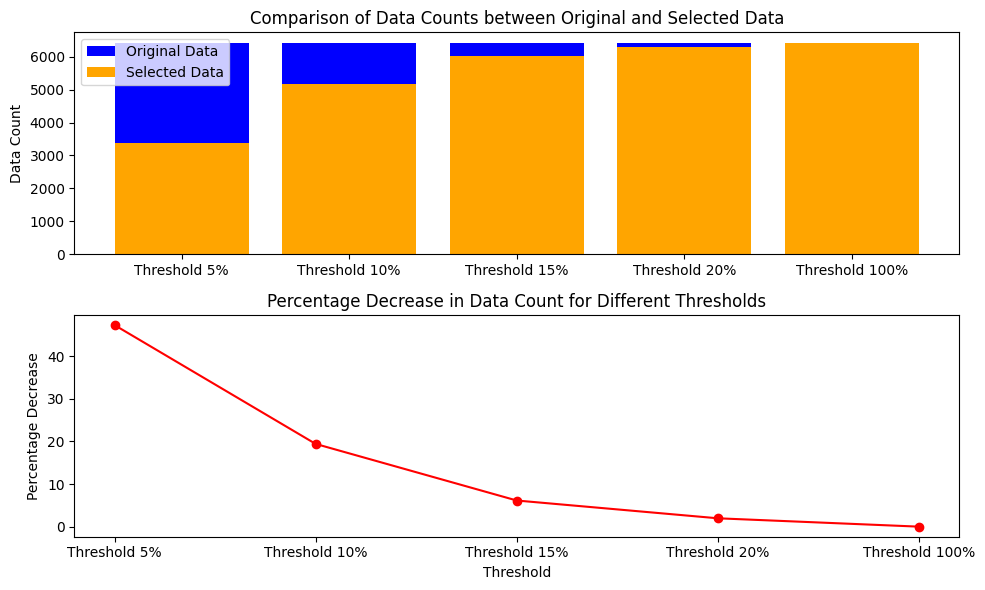

For threshold 5%, selected data has decreased by 47.28% compared to the original data.
For threshold 10%, selected data has decreased by 19.41% compared to the original data.
For threshold 15%, selected data has decreased by 6.13% compared to the original data.
For threshold 20%, selected data has decreased by 1.96% compared to the original data.
For threshold 100%, selected data has decreased by 0.00% compared to the original data.


In [12]:
import os
import matplotlib.pyplot as plt

# List of threshold values
thresholds = [5, 10, 15, 20, 100]

# Folder paths
folder1 = f'./train/img[0~100]/'  # Original data folder

# Visualization data
data_counts_original = []
data_counts_selected = []
percentage_decreases = []

# Calculate data counts and percentage decreases for each threshold
for thres in thresholds:
    folder2 = f'./train/img[0~{thres}]/'  # Selected data folder
    
    count1 = len(os.listdir(folder1))
    count2 = len(os.listdir(folder2))
    
    data_counts_original.append(count1)
    data_counts_selected.append(count2)
    
    percentage_decrease = ((count1 - count2) / count1) * 100
    percentage_decreases.append(percentage_decrease)

# Visualization
labels = [f"Threshold {thres}%" for thres in thresholds]

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(labels, data_counts_original, color='blue', label='Original Data')
plt.bar(labels, data_counts_selected, color='orange', label='Selected Data')
plt.ylabel('Data Count')
plt.title('Comparison of Data Counts between Original and Selected Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(labels, percentage_decreases, marker='o', color='red')
plt.xlabel('Threshold')
plt.ylabel('Percentage Decrease')
plt.title('Percentage Decrease in Data Count for Different Thresholds')

plt.tight_layout()
plt.show()

for i, thres in enumerate(thresholds):
    print(f"For threshold {thres}%, selected data has decreased by {percentage_decreases[i]:.2f}% compared to the original data.")


#### Object Ratio (0 제거)

In [13]:
import shutil

# 임계값 리스트 설정
thresholds = [5, 10, 15, 20, 100]

for thres in tqdm(thresholds):
    # 조건에 해당하는 행 선택
    selected_rows = building_ratio[(building_ratio['Object Ratio'] <= thres) & (building_ratio['Object Ratio'] > 0)]

    # 복사할 디렉터리 경로 생성
    new_image_dir = f"./train/img(0~{thres}]/"
    new_mask_dir = f"./train/mask(0~{thres}]/"

    os.makedirs(new_mask_dir, exist_ok=True)
    os.makedirs(new_image_dir, exist_ok=True)

    for index, row in tqdm(selected_rows.iterrows()):
        mask_filename = row['Mask Image']  # 예: image_name_mask.png
        image_filename = mask_filename.replace("_mask.png", ".png")  # 예: image_name.png

        # 관련 이미지 복사
        original_image_path = f"./train/img[0~100]/{image_filename}"
        new_image_path = os.path.join(new_image_dir, image_filename)
        shutil.copy(original_image_path, new_image_path)
        
        # 마스크 이미지 복사
        original_mask_path = f"./train/mask[0~100]/{mask_filename}"
        new_mask_path = os.path.join(new_mask_dir, mask_filename)
        shutil.copy(original_mask_path, new_mask_path)

print("복사가 완료되었습니다.")

3045it [00:09, 323.29it/s]0<?, ?it/s]
4836it [00:16, 296.03it/s]9<00:37,  9.43s/it]
5689it [00:19, 293.76it/s]5<00:40, 13.49s/it]
5957it [00:20, 289.92it/s]5<00:32, 16.18s/it]
6083it [00:19, 313.12it/s]5<00:17, 17.90s/it]
100%|██████████| 5/5 [01:25<00:00, 17.02s/it]

복사가 완료되었습니다.


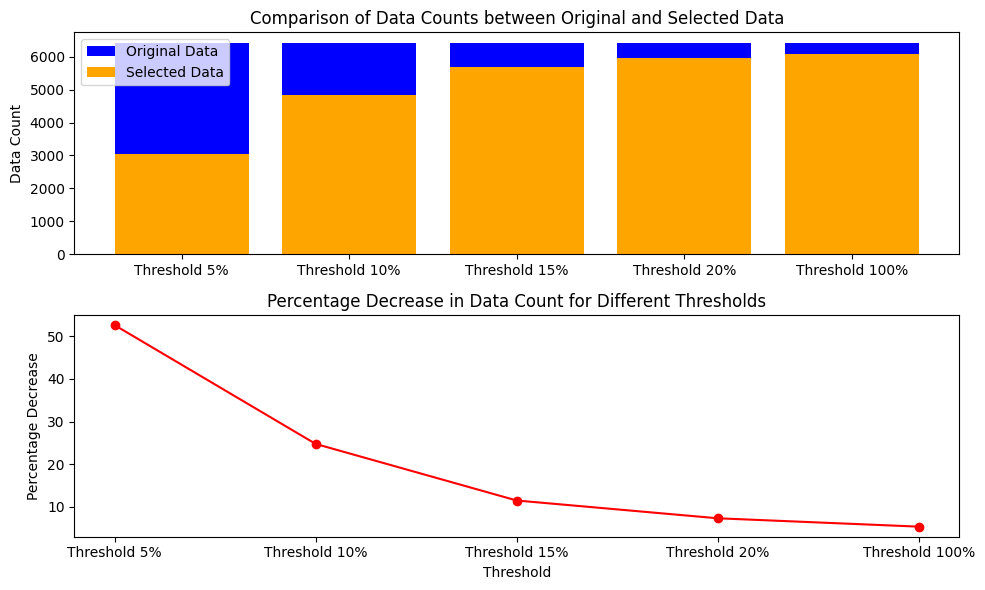

For threshold 5%, selected data has decreased by 52.61% compared to the original data.
For threshold 10%, selected data has decreased by 24.74% compared to the original data.
For threshold 15%, selected data has decreased by 11.47% compared to the original data.
For threshold 20%, selected data has decreased by 7.30% compared to the original data.
For threshold 100%, selected data has decreased by 5.34% compared to the original data.


In [14]:
import os
import matplotlib.pyplot as plt

# List of threshold values
thresholds = [5, 10, 15, 20, 100]

# Folder paths
folder1 = f'./train/img[0~100]/'  # Original data folder

# Visualization data
data_counts_original = []
data_counts_selected = []
percentage_decreases = []

# Calculate data counts and percentage decreases for each threshold
for thres in thresholds:
    folder2 = f'./train/img(0~{thres}]/'  # Selected data folder
    
    count1 = len(os.listdir(folder1))
    count2 = len(os.listdir(folder2))
    
    data_counts_original.append(count1)
    data_counts_selected.append(count2)
    
    percentage_decrease = ((count1 - count2) / count1) * 100
    percentage_decreases.append(percentage_decrease)

# Visualization
labels = [f"Threshold {thres}%" for thres in thresholds]

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.bar(labels, data_counts_original, color='blue', label='Original Data')
plt.bar(labels, data_counts_selected, color='orange', label='Selected Data')
plt.ylabel('Data Count')
plt.title('Comparison of Data Counts between Original and Selected Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(labels, percentage_decreases, marker='o', color='red')
plt.xlabel('Threshold')
plt.ylabel('Percentage Decrease')
plt.title('Percentage Decrease in Data Count for Different Thresholds')

plt.tight_layout()
plt.show()

for i, thres in enumerate(thresholds):
    print(f"For threshold {thres}%, selected data has decreased by {percentage_decreases[i]:.2f}% compared to the original data.")
